# Chapter 6 Problem 5 (Gelman & Hill)

*Tobit model for mixed discrete/continuous data: experimental data from the National Supported Work example are available in the folder `lalonde`. Use the treatment indicator and pre-treatment variables to predict post-treatment (1978) earnings using a tobit model. Interpret the model coefficients.*

In [67]:
require("arm")
require("foreign")
require("ggplot2")
require("VGAM")
require("gridExtra")

The dataset for this exercise is a smaller version of the one from the Dehejia/Wahba paper. Our dataset includes for socio-democraphic and earning data. In particular `re74`, `re75` and `re78` (the latter is the outcome variable we want to predict) correspond to the real earnings in 1974, 1975 and 1978.

In [68]:
# download the dataset
nsw <- read.dta("http://www.stat.columbia.edu/~gelman/arm/examples/lalonde/NSW.dw.obs.dta")

# create factor variables 
nsw$sample <- factor(nsw$sample, labels=c("NSW", "CPS", "PSID"))
nsw$black <- factor(nsw$black)
nsw$hisp <- factor(nsw$hisp)
nsw$nodegree <- factor(nsw$nodegree)
nsw$married <- factor(nsw$married)
nsw$treat <- factor(nsw$treat)
nsw$educ_cat4 <- factor(nsw$educ_cat4, labels=c("less than high school", "high school", "sm college", "college"))

# create a function to normalise and standardise numeric variables
standardise <- function(X) {
    cols <- ncol(X)
    for (c in 1:cols) {
        if (is.numeric(X[, c])) {
            start <- ncol(X)
            c.c <- (X[, c] - mean(X[, c], na.rm=TRUE)) / (2 * sd(X[, c], na.rm=TRUE))
            X[start+1] <- c.c
            colnames(X)[start+1] <- paste0("c.", colnames(X)[c])
        }
    }
    return(X)
}

# normalise and standardise numeric variables
nsw <- standardise(nsw)
summary(nsw)

      age             educ       black     married   nodegree       re74       
 Min.   :16.00   Min.   : 0.00   0:16711   0: 5093   0:13045   Min.   :     0  
 1st Qu.:24.00   1st Qu.:11.00   1: 1956   1:13574   1: 5622   1st Qu.:  4898  
 Median :31.00   Median :12.00                                 Median : 15525  
 Mean   :33.37   Mean   :12.02                                 Mean   : 14621  
 3rd Qu.:42.00   3rd Qu.:14.00                                 3rd Qu.: 23882  
 Max.   :55.00   Max.   :18.00                                 Max.   :137149  
      re75             re78        hisp       sample      treat    
 Min.   :     0   Min.   :     0   0:17423   NSW :  185   0:18482  
 1st Qu.:  4726   1st Qu.:  6158   1: 1244   CPS :15992   1:  185  
 Median : 14899   Median : 16957             PSID: 2490            
 Mean   : 14253   Mean   : 15657                                   
 3rd Qu.: 23274   3rd Qu.: 25565                                   
 Max.   :156653   Max.   :121174

Before start to do some regression, we will plot the outcome variable in order to get some insight into what is the best way to model it. 

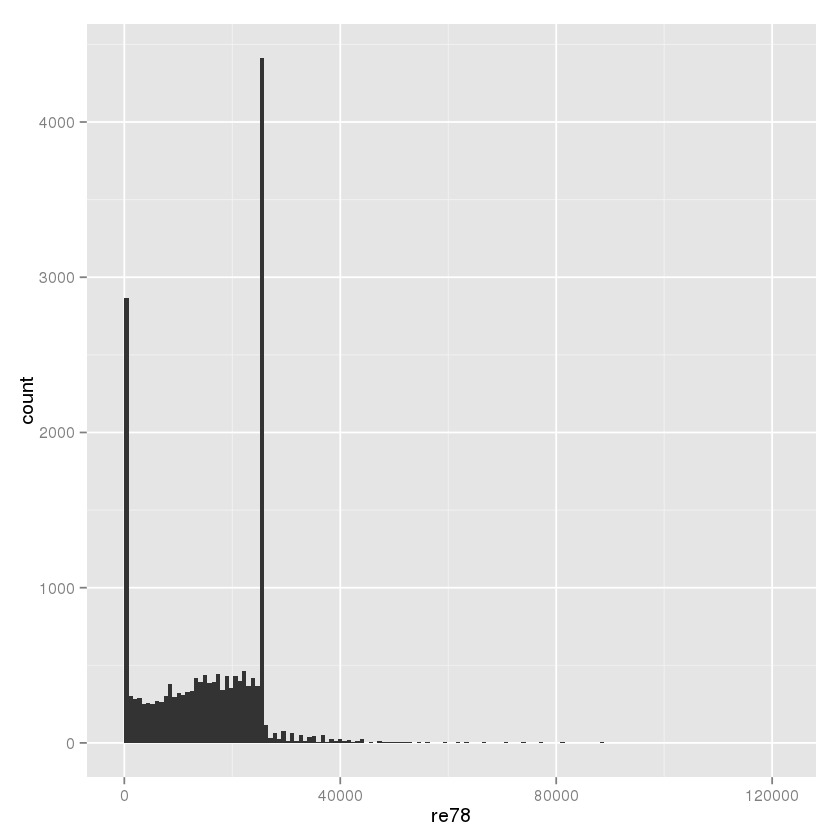

In [69]:
ggplot(data=nsw, aes(x=re78)) + geom_histogram(binwidth=(range(nsw$re78)[2] - range(nsw$re78)[1])/150)

From the graph above is pretty clear we are dealing with censored data. The spike around \$25,564.66 is pretty interesting and could due to censoring in fact or a combination of tax policies which highly influence the declared earning for subjects with high incomes. The following chunk will investigate what's happening around \$25,564.66.

[1] "The mode is: $25564.67"


stat_bin: binwidth defaulted to range/30. Use 'binwidth = x' to adjust this.


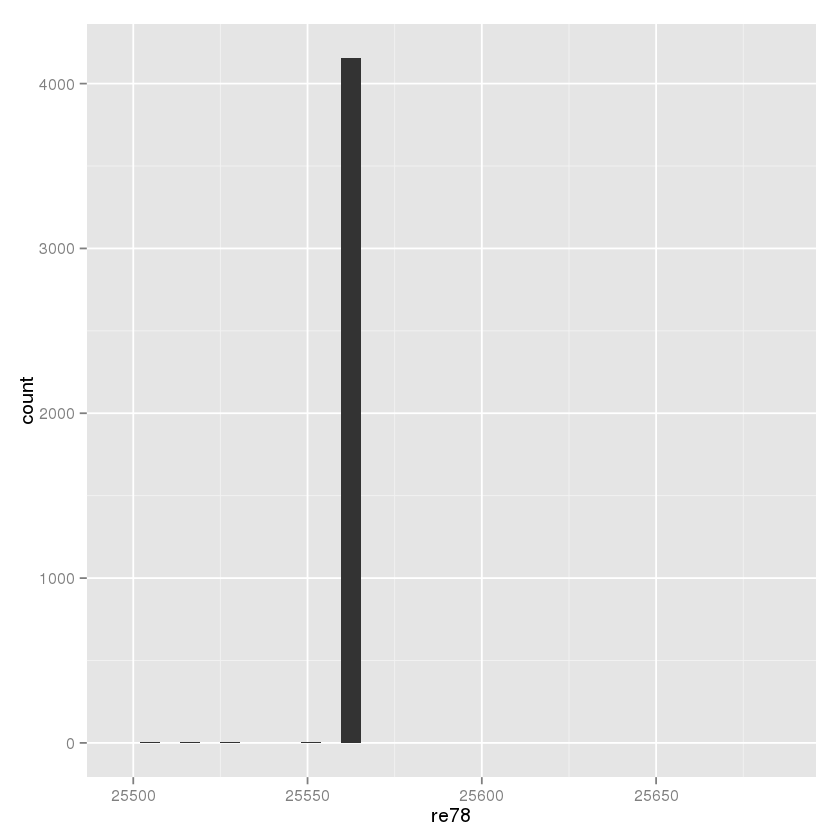

In [70]:
modex <- function(x) {  # call it modex not to override the standard mode command
    ux <- unique(x)
    ux[which.max(tabulate(match(x, ux)))]
}

print(paste0("The mode is: ", sprintf("$%3.2f", modex(nsw$re78))))
ggplot(nsw[nsw$re78>=25500 & nsw$re78<25700,], aes(x=re78)) + geom_histogram()

`re78` has a very clear bi-modal distribution, concentrated on the values 0 and \$25,564.67. The rest on the density is mainly distributed between these two values, with rare observations above \$25,564.67. From the previous series of commands we notice the distribution around value 25,564.67 is not random at all and is almost null. The value \$25,564.67 for some reason appears very often. This looks like a case of censored data. In particular, it seems that there are two underlying distributions: 1) values from 0 to \$25,563 and 2) from \$25,564.67 to approximately \$100,000.

To model such distribution, we will start fitting a logistic regression to classify observations as belonging to a value lower than or greater than \$25,564.67. Then we will split the dataset into two smaller sets, based on the predictions of the logistic model. As a final stage, we will fit two Tobit regressions, to predict the `re78` variables from zero to \$25,563 and from \$25,564 to Inf.

We will proceed creating a binary variable that takes value `gte` when earnings in 1978 are greater or equal than $25,564.67, or `lt` when lower than that threshold. We will use this variable as the outcome variable of the logistic regression model.

In [71]:
nsw$outcome <- rep(NA, nrow(nsw))
nsw$outcome <- ifelse(nsw$re78>=25564.669921875, 1, 0)
nsw$outcome <- factor(nsw$outcome, labels=c("lt", "gte"))

We will plot a few variables against the new created `outcome` variable to have a better understanding of which variables we should include in our logistic regression model. 

     
          0     1
  lt  11947  1666
  gte  4764   290

     
          0     1
  lt  12594  1019
  gte  4829   225

     
         0    1    2    3    4    5    6    7    8    9   10   11   12   13
  lt    37   12   40   78  107  125  239  293  837  811 1116 1073 5165  867
  gte    2    2    6   11   13   17   39   45  182  142  203  192 1979  353
     
        14   15   16   17   18
  lt   882  383  932  281  335
  gte  465  155  719  263  266

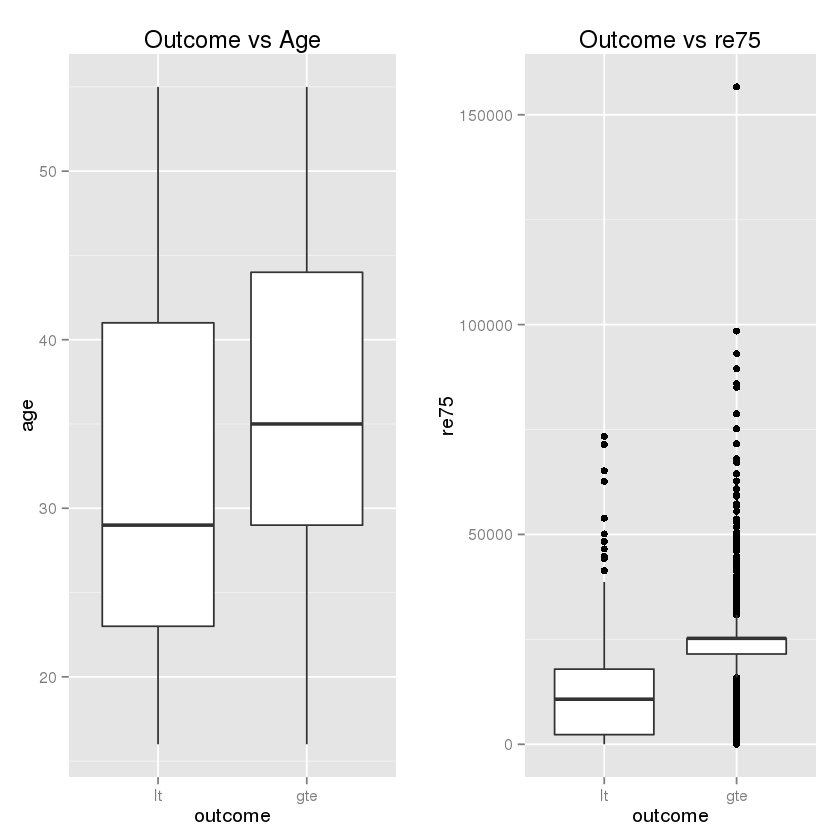

In [72]:
p1 <- ggplot(data=nsw, aes(x=outcome, y=age)) + geom_boxplot() + labs(title="Outcome vs Age")
p2 <- ggplot(data=nsw, aes(x=outcome, y=re75)) + geom_boxplot() + labs(title="Outcome vs re75")
grid.arrange(p1, p2, nrow=1)

table(nsw$outcome, nsw$black)
table(nsw$outcome, nsw$hisp)
table(nsw$outcome, nsw$educ)

We will fit the first part of the two-stage model we mentioned above. `fit1` will try to predict earning greater than or equal to \$25564.67.

In [73]:
fit1 <- glm(outcome ~ c.age + c.educ + c.re75 + black + married, family=binomial(link="logit"), data=nsw)
display(fit1)

glm(formula = outcome ~ c.age + c.educ + c.re75 + black + married, 
    family = binomial(link = "logit"), data = nsw)
            coef.est coef.se
(Intercept) -1.93     0.06  
c.age       -0.05     0.05  
c.educ       0.66     0.05  
c.re75       3.89     0.07  
black1      -0.30     0.08  
married1     0.33     0.06  
---
  n = 18667, k = 6
  residual deviance = 14505.0, null deviance = 21803.0 (difference = 7298.1)


As a first benchmark we will compute the error rate of `fit1` on the training data.

In [74]:
predicted <- predict(fit1, nsw, type="response")
y <- ifelse(nsw$re78>=25564.669921875, 1, 0)

# compute error rate
error.rate <- mean((predicted>0.5 & y==0) | (predicted<.5 & y==1))
print(paste0("Error rate: ", sprintf("%.2f%%", 100*error.rate)))

[1] "Error rate: 15.88%"


The logistic regression achieves an error rate (on the training set) of just 16%. This is quite a decent starting point. We will now use the predictions from this first model to divide the dataset into two smaller sets. The first one will be used to fit a Tobit regression with the aim of predicting `re78` values from 0 to $25,563, and a second set to predict values above such threshold.

In [75]:
# nsw$predicted.outcome <- predict(m1, nsw, type="response")

# # create two subsets based on 
# set1 <- nsw[nsw$predicted.outcome<0.5,]
# set2 <- nsw[nsw$predicted.outcome>=0.5,]

In [76]:
fit2.a <-vglm(re78 ~ c.age + c.educ + c.re75, tobit(Lower=0, Upper=25563), data=nsw, subset=re78<25564)
summary(fit2.a)


Call:
vglm(formula = re78 ~ c.age + c.educ + c.re75, family = tobit(Lower = 0, 
    Upper = 25563), data = nsw, subset = re78 < 25564)

Pearson residuals:
               Min      1Q  Median     3Q    Max
mu       -137.6002 -0.7610  0.1368 0.6831  2.034
loge(sd)   -0.9974 -0.7217 -0.4189 0.2442 72.432

Coefficients:
                Estimate Std. Error  z value Pr(>|z|)    
(Intercept):1  1.237e+04  7.933e+01  155.976  < 2e-16 ***
(Intercept):2  9.027e+00  7.283e-03 1239.450  < 2e-16 ***
c.age         -3.308e+03  1.533e+02  -21.575  < 2e-16 ***
c.educ        -6.541e+02  1.510e+02   -4.331 1.49e-05 ***
c.re75         1.362e+04  1.908e+02   71.368  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Number of linear predictors:  2 

Names of linear predictors: mu, loge(sd)

Dispersion Parameter for tobit family:   1

Log-likelihood: -118527.5 on 27221 degrees of freedom

Number of iterations: 5 

In [77]:
fit2.b <- vglm(re78 ~ c.age + c.educ + c.re75, tobit(Lower=25564, Upper=Inf), data=nsw, subset=re78>=25564)
summary(fit2.b)


Call:
vglm(formula = re78 ~ c.age + c.educ + c.re75, family = tobit(Lower = 25564, 
    Upper = Inf), data = nsw, subset = re78 >= 25564)

Pearson residuals:
            Min      1Q  Median      3Q   Max
mu       -3.581 -0.4993 -0.3436  0.1337  32.1
loge(sd) -1.009 -0.8548 -0.7314 -0.5986 333.6

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept):1  2.343e+04  1.519e+02 154.217  < 2e-16 ***
(Intercept):2  8.700e+00  1.285e-02 677.246  < 2e-16 ***
c.age         -1.263e+03  2.294e+02  -5.504 3.71e-08 ***
c.educ         8.253e+02  2.023e+02   4.080 4.51e-05 ***
c.re75         9.322e+03  2.511e+02  37.130  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Number of linear predictors:  2 

Names of linear predictors: mu, loge(sd)

Dispersion Parameter for tobit family:   1

Log-likelihood: -51141.56 on 10103 degrees of freedom

Number of iterations: 18 

Treatment is not statistically significant neither in `fit2.a` nor in `fit2.b`. Therefore we proceeded removing it from the model specifications. In addition to that, in the second Tobit model (`fit2.b`) including `treat` as a predictor leads to a *nonidentifiability* issue.

To benchmark out models, we will compute the root-mean-square error (RMSE) on the training data. This is an overly optimistic statistic but, in absence of unseen data, is a decent starting point for evaluating out models. On a real world application we would do cross-validation to avoid overfitting the data. However, for the purposes of this exercise we will not apply such technique.

[1] "RMSE: 8482.20"


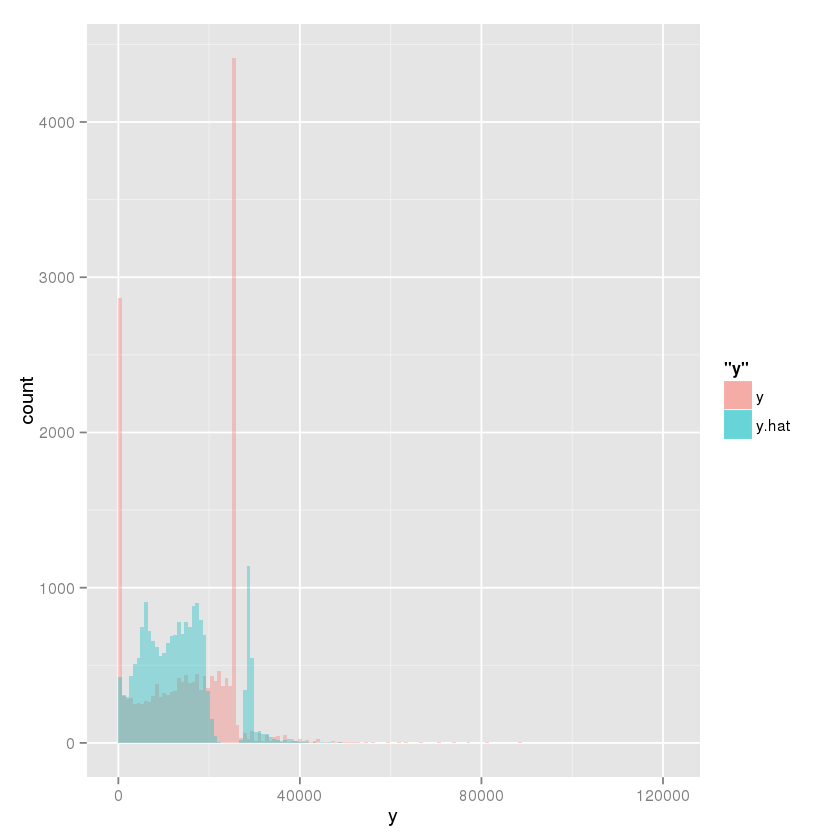

In [78]:
# make predictions using model 
y.hat <- ifelse(predict(fit1, nsw)<0.5, 
                ifelse(predict(fit2.a, nsw)<0, 0, predict(fit2.a, nsw)), 
                predict(fit2.b, nsw)) # predicted values can't go below 0
y <- nsw$re78
print(paste0("RMSE: ", sprintf("%.2f", sqrt(mean((y-y.hat)**2)))))

ggplot(data=data.frame(cbind(y=y, y.hat=y.hat))) +
    geom_histogram(aes(x=y, fill="y"), alpha=.35, binwidth=(range(y)[2] - range(y)[1])/150) +
    geom_histogram(aes(x=y.hat, fill="y.hat"), alpha=.35, binwidth=(range(y)[2] - range(y)[1])/150)

It's evident how our initial model doesn't describe well the training data. `fit2.a` in fact underestimate the number of observations where earning in 1978 are zero, and spread that density over the rest of the other possible outcomes. Similarly, `fit2.b` wrongly shifts the distribution towards values above \$25,564.66. 

To overcome the deficits of `fit2.b` we tried a naive approach which replaces the prediction of this model with the hard-coded value \$25564.67.

[1] "RMSE: 8692.13"


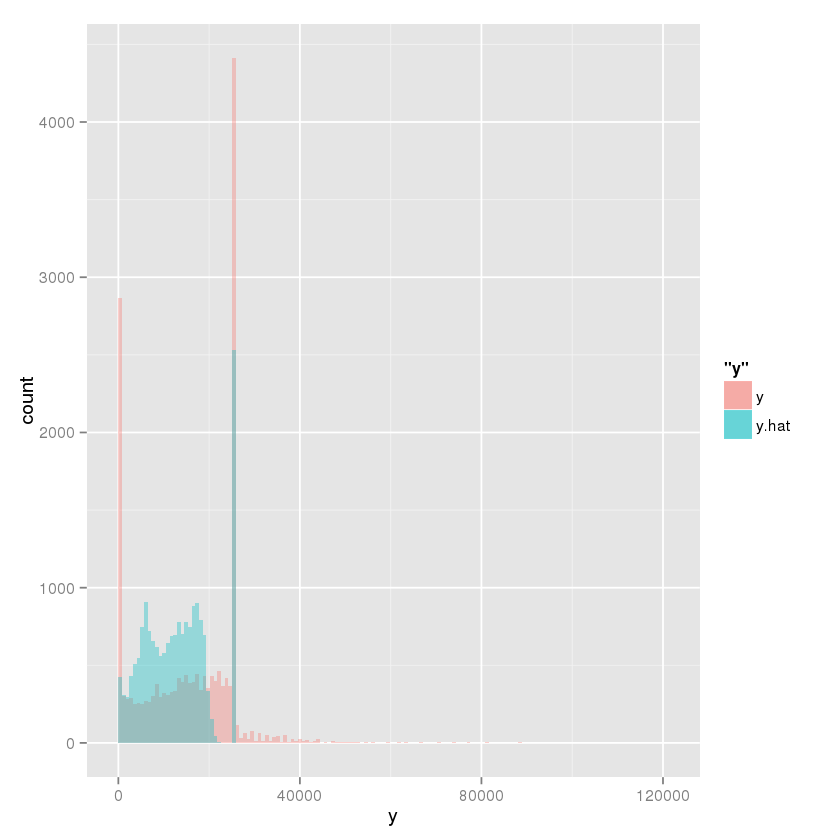

In [79]:
y.hat <- ifelse(predict(fit1, nsw)<0.5, 
                ifelse(predict(fit2.a, nsw)<0, 0, predict(fit2.a, nsw)), 
                25564.669921875) 
y <- nsw$re78
print(paste0("RMSE: ", sprintf("%.2f", sqrt(mean((y-y.hat)**2)))))

ggplot(data=data.frame(cbind(y=y, y.hat=y.hat))) +
    geom_histogram(aes(x=y, fill="y"), alpha=.35, binwidth=(range(y)[2] - range(y)[1])/150) +
    geom_histogram(aes(x=y.hat, fill="y.hat"), alpha=.35, binwidth=(range(y)[2] - range(y)[1])/150)

This more naive formulation doesn't improve the RMSE. Nevertheless it highlights how the distribution is clearly bimodal and further adjustments are needed to improve the model fit.